<a href="https://colab.research.google.com/github/nooblette/SentimentAnalysis/blob/main/MovieReview_SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

True
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
movie_id : 10001 train data : (287, 674) 287  /  test data : (123, 674) 123


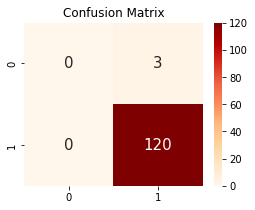

movie_id : 10002 train data : (287, 686) 287  /  test data : (123, 686) 123


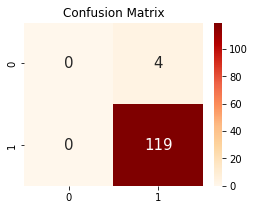

movie_id : 10003 train data : (287, 776) 287  /  test data : (123, 776) 123


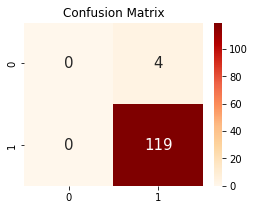

movie_id : 10004 train data : (287, 582) 287  /  test data : (123, 582) 123


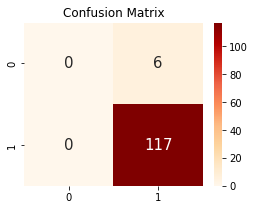

movie_id : 10005 train data : (287, 739) 287  /  test data : (123, 739) 123


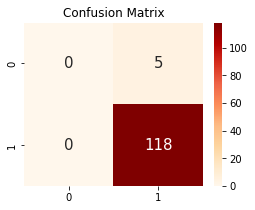

movie_id : 10006 train data : (287, 664) 287  /  test data : (123, 664) 123


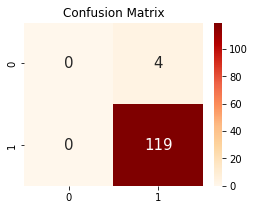

movie_id : 10007 train data : (287, 647) 287  /  test data : (123, 647) 123


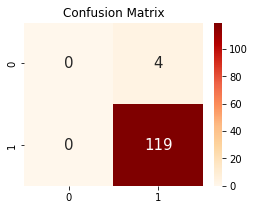

movie_id : 10008 train data : (245, 510) 245  /  test data : (105, 510) 105


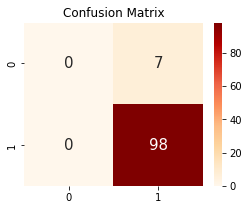

movie_id : 10009 train data : (154, 270) 154  /  test data : (67, 270) 67


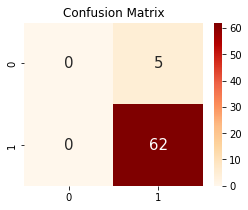

SAMPLE OUTPUT movie_id 10001 ~ 10009
--- movie_id is  10001
positive keywords [['인생', 0.3194403031239633], ['최고', 0.19584517435557483], ['프레', 0.17426852294063136], ['토토', 0.15974884884843338], ['사랑', 0.14882861957603935], ['눈물', 0.14014117117834937], ['음악', 0.11296642809110666], ['장면', 0.11176768336077118], ['마지막', 0.10559259917048062], ['나이', 0.08524593980812994], ['생각', 0.07884250880655827], ['처음', 0.07664053791560925], ['시절', 0.07474554488178022], ['이유', 0.0738935454777724], ['모리꼬', 0.07223567903733649], ['보고', 0.07195746909014608], ['가슴', 0.07138336582235177], ['가장', 0.07111837701435891], ['감독판', 0.06744094896928757], ['모든', 0.06614931795085245]]
negative keywords [['포인트', -0.8418617664383489], ['극찬', -0.7499501510478083], ['편집', -0.6476082818606954], ['노잼', -0.5668059682874572], ['이영화', -0.5623202861535079], ['대체', -0.5304733457379908], ['보통', -0.5238067796977194], ['수준', -0.5238067796977194], ['치면', -0.46640763494844095], ['감흥', -0.4601348762290054], ['워낙', -0.4601348762290054],

In [17]:
%matplotlib inline
#!apt-get update
#!apt-get install g++ openjdk-8-jdk python-dev python3-dev
#!pip3 install JPype1-py3
#!pip3 install konlpy
#!JAVA_HOME="/usr/lib/jvm/java-1.11.0-openjdk-amd64"
#!pip install sklearn

import jpype
print(jpype.isJVMStarted()) #return False:not running or 0:running

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from urllib.request import urlopen, urlretrieve
from urllib.error import URLError, HTTPError
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize 
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')
feeling_kw_movie = dict()  # Save feeling keword list for each movie_id

stop_words = urlopen("https://raw.githubusercontent.com/nooblette/SentimentAnalysis/main/K_Stopword.txt")
stop_words = list((str(stop_words.read(), 'utf-8').split('\n')))  # 불용어 단어 리스트
stop_words += ['영화']  # 영화 리뷰 특화 불용어 단어 리스트 추가

def rating_to_label(rating):
    if rating > 5:
        return 1
    else:
        return 0

def apply_regular_expression(text):
    hangul = re.compile('[^ ㄱ-ㅣ 가-힣|0-9]')  # 한글 추출 규칙: 띄어 쓰기(1 개)를 포함한 한글
    result = hangul.sub('', text)  # 위에 설정한 "hangul"규칙을 "text"에 적용(.sub)시킴
    return result

def remove_stopword(text):
    return [word for word in text if not word in stop_words]

def text_cleaning(text):
    corpus = apply_regular_expression(text)  # 특수문자 제거
    okt = Okt()  # 명사 형태소 추출 함수
    corpus = okt.nouns(corpus)  # 명사만 추출
    corpus = [x for x in corpus if len(x) > 1]  # 두 글자 이상 단어만 사용
    corpus = remove_stopword(corpus)  # 불용어 제거
    return corpus

movie_id_feeling_keywords = dict()  # 영화별 긍정, 부정 키워드 리스트 저장

for i in range(10001, 10010):
#for i in range(10001, 142622):  # 데이터 부족으로 모든 리뷰에 대해 진행 불가
  try:
    movie_id = str(i)
    # ***************************** #
    # ****** 데이터 가져오기 ****** #
    # ***************************** #
    with urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/raw/" + movie_id + ".json") as url1, urlopen("https://raw.githubusercontent.com/nooblette/SentimentAnalysis/main/new_review_data/jsonfile_raw/" + movie_id + ".json") as url2:
      review_json_file1 = url1.read()
      review_json = json.loads(review_json_file1.decode('utf-8'))

      review_json_file2 = url2.read()
      review_json += json.loads(review_json_file2)

      # review, rating, movie_id = review_json[idx]['review'], review_json[idx]['rating'], review_json[idx]['movie_id']

      vect = CountVectorizer(tokenizer = lambda x: text_cleaning(x))
      bow_vect = vect.fit_transform(review['review'] for review in review_json)
      word_list = vect.get_feature_names()
      count_list = bow_vect.toarray().sum(axis=0)
      # "단어" - "총 등장 횟수" Matching
      word_count_dict = dict(zip(word_list, count_list))




      # ************************** #
      # ********* TF-IDF ********* #
      # ************************** #
      tfidf_vectorizer = TfidfTransformer()
      tf_idf_vect = tfidf_vectorizer.fit_transform(bow_vect)
      # row -> 한 리뷰를 의미, column -> 한 단어를 의미.

      invert_index_vectorizer = {v: k for k, v in vect.vocabulary_.items()}

      count = {1:0, 0:0}  # 긍정 리뷰와 부정 리뷰의 개수 저장
      for review in review_json:
        review['label'] = rating_to_label(int(review['rating']))
        count[review['label']] += 1

      # 학습 데이터가 충분하지 않은 경우 우선 넘어가도록 진행
      if count[0] < 2 or count[1] < 2:
        continue

      x = tf_idf_vect
      y = [review['label'] for review in review_json]
      x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=1)

      # train, test data set size 확인
      print("movie_id :", movie_id, end = ' ')
      print("train data :", x_train.shape, len(y_train), end="  /  ")
      print("test data :", x_test.shape, len(y_test))



      # ***************************** #
      # ********* 학습 진행 ********* #
      # ***************************** #
      # fit in training set
      lr = LogisticRegression(random_state = 0)
      lr.fit(x_train, y_train)

      # predict in test set
      y_pred = lr.predict(x_test)



      # ***************************** #
      # ********* 모델 평가 ********* #
      # ***************************** #
      # classification result for test set

      #print('accuracy: %.2f' % accuracy_score(y_test, y_pred))
      #print('precision: %.2f' % precision_score(y_test, y_pred))

      confu = confusion_matrix(y_true = y_test, y_pred = y_pred)

      plt.figure(figsize=(4, 3))
      sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
      plt.title('Confusion Matrix')
      plt.show()


      # ***************************************** #
      # ********* 긍정 부정 키워드 분석 ********* #
      # ***************************************** #
      coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse = True)  # 긍정 키워드 리스트
      coef_neg_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse = False) # 부정 키워드 리스트

      invert_index_vectorizer = {v: k for k, v in vect.vocabulary_.items()}

      # 키워드 리스트 출력
      '''
      print("긍정 키워드 top 20")
      for coef in coef_pos_index[:20]:  # 긍정 키워드 top 20
        print(invert_index_vectorizer[coef[1]], coef[0])

      print("\n부정 키워드 top 20")
      for coef in coef_neg_index[:20]:  # 부정 키워드 top 20
        print(invert_index_vectorizer[coef[1]], coef[0])
      '''

      # 영화별로 키워드 리스트 저장
      movie_id_feeling_keywords[movie_id] = {
          'positive' : [[invert_index_vectorizer[coef[1]], coef[0]] for coef in coef_pos_index[:20] if coef[0] > 0.0],
          'negative' : [[invert_index_vectorizer[coef[1]], coef[0]] for coef in coef_neg_index[:20] if coef[0] < 0.0]
      }

  except HTTPError as e:
    continue

print("SAMPLE OUTPUT movie_id 10001 ~ 10009")
for i in range(10001, 10010):
  i = str(i)
  print('--- movie_id is ', i)
  print('positive keywords', movie_id_feeling_keywords[i]['positive'])
  print('negative keywords', movie_id_feeling_keywords[i]['negative'])
  print('\n')

f = open("output.txt", "w", encoding = 'utf-8')

for movie_id, keywords in movie_id_feeling_keywords.items():
  positive = keywords['positive']
  negative = keywords['negative']
  f.write(f'{movie_id} : {positive}, {negative}\n')

f.close()


# References
# https://hyemin-kim.github.io/2020/08/29/E-Python-TextMining-2/
# https://rfriend.tistory.com/475
# https://www.ranks.nl/stopwords/korean
# https://shakeratos.tistory.com/18

# 새 섹션

In [ ]:
""